In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
aug = pd.read_csv("speeddata_Aug.csv")
sep = pd.read_csv("speeddata_Sep.csv")

In [9]:
df = pd.concat([aug, sep], ignore_index=True)
print(df.shape)
df.head()

(1855589, 4)


,road_id,day_id,time_id,speed
0,1,1,1,40.893
1,1,1,2,41.938
2,1,1,3,44.098
3,1,1,4,44.483
4,1,1,5,44.172


In [11]:
df['datetime'] = pd.Timestamp(2016,8,1) + pd.to_timedelta(
    (df['day_id'] - 1) * 1440 + (df['time_id'] - 1) * 10,
    unit='m'
)

In [13]:
df.head()

,road_id,day_id,time_id,speed,datetime
0,1,1,1,40.893,2016-08-01 00:00:00
1,1,1,2,41.938,2016-08-01 00:10:00
2,1,1,3,44.098,2016-08-01 00:20:00
3,1,1,4,44.483,2016-08-01 00:30:00
4,1,1,5,44.172,2016-08-01 00:40:00


In [15]:
print(df.describe())

            road_id        day_id       time_id         speed  \
count  1.855589e+06  1.855589e+06  1.855589e+06  1.855589e+06   
mean   1.075490e+02  3.117414e+01  7.250006e+01  3.900740e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.054000e+00   
25%    5.400000e+01  1.600000e+01  3.700000e+01  3.240600e+01   
50%    1.070000e+02  3.100000e+01  7.200000e+01  3.937400e+01   
75%    1.620000e+02  4.600000e+01  1.080000e+02  4.631900e+01   
max    2.140000e+02  6.100000e+01  1.440000e+02  1.192700e+02   
std    6.197938e+01  1.761503e+01  4.156805e+01  1.082419e+01   

                            datetime  
count                        1855589  
mean   2016-08-31 16:05:45.530394112  
min              2016-08-01 00:00:00  
25%              2016-08-16 09:50:00  
50%              2016-08-31 19:50:00  
75%              2016-09-15 22:40:00  
max              2016-09-30 23:50:00  
std                              NaN  


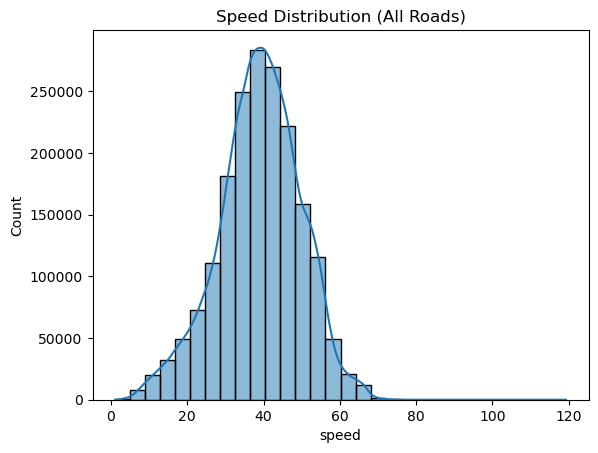

In [17]:
sns.histplot(df['speed'], bins=30, kde=True)
plt.title("Speed Distribution (All Roads)")
plt.show()

In [19]:
df['hour'] = df['datetime'].dt.hour

In [21]:
avg_speed_by_hour = df.groupby('hour')['speed'].mean()

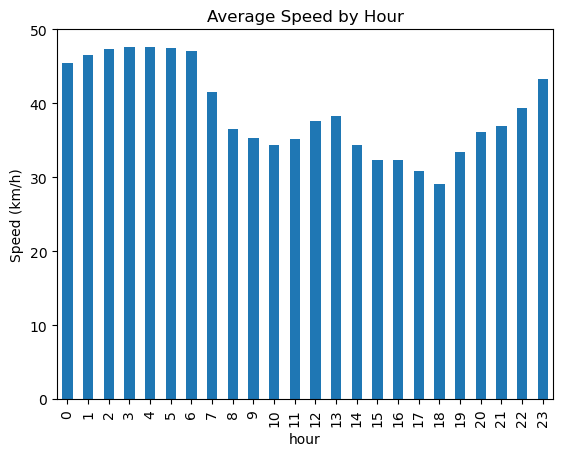

In [23]:
avg_speed_by_hour.plot(kind='bar', title='Average Speed by Hour')
plt.ylabel('Speed (km/h)')
plt.show()

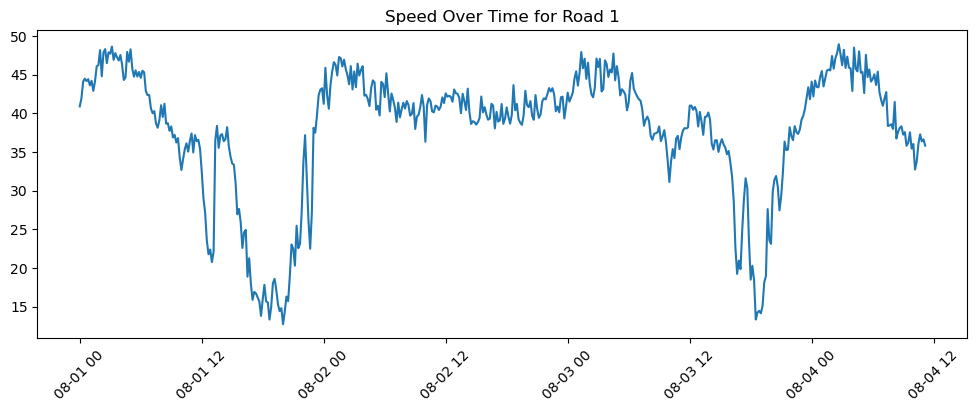

In [68]:
road_id = 1
segment = df[df['road_id'] == road_id]
plt.figure(figsize=(12,4))
plt.plot(segment['datetime'][:500], segment['speed'][:500])
plt.title(f"Speed Over Time for Road {road_id}")
plt.xticks(rotation=45)
plt.show()

In [25]:
df = df.sort_values(['road_id', 'datetime'])

In [27]:
df['lag1'] = df.groupby('road_id')['speed'].shift(1)
df['lag2'] = df.groupby('road_id')['speed'].shift(2)
df['lag3'] = df.groupby('road_id')['speed'].shift(3)

In [29]:
df['day_of_week'] = df['datetime'].dt.dayofweek
df = df.dropna(subset=['lag1', 'lag2', 'lag3'])
df.head()

,road_id,day_id,time_id,speed,datetime,hour,lag1,lag2,lag3,day_of_week
3,1,1,4,44.483,2016-08-01 00:30:00,0,44.098,41.938,40.893,0
4,1,1,5,44.172,2016-08-01 00:40:00,0,44.483,44.098,41.938,0
5,1,1,6,44.416,2016-08-01 00:50:00,0,44.172,44.483,44.098,0
6,1,1,7,43.622,2016-08-01 01:00:00,1,44.416,44.172,44.483,0
7,1,1,8,44.202,2016-08-01 01:10:00,1,43.622,44.416,44.172,0


In [31]:
df_small = df.sample(10_000, random_state=42).copy()

In [33]:
print(f"Using {len(df_small)} rows for training/testing.")

Using 10000 rows for training/testing.


In [35]:
X = df_small[['road_id', 'hour', 'day_of_week', 'lag1', 'lag2', 'lag3']]
y = df_small['speed']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (8000, 6)
Test size: (2000, 6)


In [37]:
cat_features = ['road_id', 'hour', 'day_of_week']

In [39]:
preprocessor = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)],
    remainder='passthrough'
)

In [41]:
model = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=10,   
        random_state=42,
        n_jobs=-1          
    ))
])

In [43]:
print("\nTraining the RandomForest model on 10,000 rows...")
model.fit(X_train, y_train)
print("Training completed!")


Training the RandomForest model on 10,000 rows...
Training completed!


In [49]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nModel Evaluation:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}")


Model Evaluation:
MAE  = 2.28
RMSE = 3.36
R²   = 0.91


In [55]:
def predict_speed(road_id, hour, day_of_week, lag1, lag2, lag3):
    new_data = pd.DataFrame({
        'road_id': [road_id],
        'hour': [hour],
        'day_of_week': [day_of_week],
        'lag1': [lag1],
        'lag2': [lag2],
        'lag3': [lag3]
    })
    return model.predict(new_data)[0]
print("Predicted Speed:", predict_speed(5, 14, 2, 45, 47, 50), "km/h")

Predicted Speed: 45.5693 km/h


In [61]:
joblib.dump(model, "traffic_speed_model.pkl")

['traffic_speed_model.pkl']